# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

acc_drop = metadata[metadata["genotype"] == "WT"]["Run"].tolist()
acc_drop = [acc + "_sorted.bam" for acc in acc_drop]
df_initial.drop(columns=acc_drop, inplace=True)
metadata = metadata[metadata['genotype'] == 'rpoC G17D']

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR27597785_sorted.bam,SRR27597770_sorted.bam,SRR27597817_sorted.bam,SRR27597775_sorted.bam,SRR27597772_sorted.bam,...,SRR27597819_sorted.bam,SRR27597820_sorted.bam,SRR27597784_sorted.bam,SRR27597782_sorted.bam,SRR27597780_sorted.bam,SRR27597787_sorted.bam,SRR27597778_sorted.bam,SRR27597777_sorted.bam,SRR27597779_sorted.bam,SRR27597788_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-NRS_9,CP027476.1,544,1905,+,1362,11812,2302,3717,5022,3938,...,4170,5874,14174,11710,8419,14149,8555,8085,8067,13901
gene-NRS_10,CP027476.1,2183,3316,+,1134,13922,2972,4207,6064,4868,...,4615,6729,17220,13092,10792,14935,9299,8567,8907,16122
gene-NRS_11,CP027476.1,3697,3942,+,246,4378,1079,1071,2117,1502,...,1269,1705,4744,3055,2727,3765,2205,1874,1705,3637
gene-NRS_12,CP027476.1,3939,5051,+,1113,18333,3856,4772,7295,5702,...,5006,7031,20349,15064,11588,20326,11029,10114,9635,19581
gene-NRS_13,CP027476.1,5061,6995,+,1935,39911,7252,8390,16686,10121,...,8622,11974,37759,31160,23109,41805,22892,21251,20536,41540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp037,NC_005880.2,146607,146843,+,237,5812,3465,5883,14874,9289,...,7920,12291,20726,20307,22650,5622,26671,23704,24789,4919
gene-CPT_phageK_gp036,NC_005880.2,146923,147393,+,471,7134,5505,7321,18180,11427,...,9587,14071,30068,32697,38959,8175,48089,42791,46577,7597
gene-CPT_phageK_gp035,NC_005880.2,147452,147625,+,174,3184,2164,4798,10731,6698,...,5923,8446,13518,15392,18155,3223,23209,20367,21182,2987


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time_point,treatment
0,SRR27597767,RNA-Seq,202,7463772538,PRJNA1065939,SAMN39476126,2512046940,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266305,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022484,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:02:00Z,1,GSM8022484,NRS384,SRP484313,30 min,infected with phage K
1,SRR27597768,RNA-Seq,202,7890097578,PRJNA1065939,SAMN39476127,2682705677,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266304,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022483,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:02:00Z,1,GSM8022483,NRS384,SRP484313,30 min,infected with phage K
2,SRR27597769,RNA-Seq,202,5669422900,PRJNA1065939,SAMN39476128,1920956198,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266303,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022482,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022482,NRS384,SRP484313,20 min,infected with phage K
3,SRR27597770,RNA-Seq,202,5590852576,PRJNA1065939,SAMN39476129,1845976159,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266302,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022481,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022481,NRS384,SRP484313,20 min,infected with phage K
4,SRR27597771,RNA-Seq,202,7299298078,PRJNA1065939,SAMN39476130,2412987941,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266301,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022480,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:01:00Z,1,GSM8022480,NRS384,SRP484313,20 min,infected with phage K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,SRR27597816,RNA-Seq,202,5933188238,PRJNA1065939,SAMN39476121,1976892690,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266256,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022489,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:02:00Z,1,GSM8022489,NRS384,SRP484313,40 min,infected with phage K
50,SRR27597817,RNA-Seq,202,6067617016,PRJNA1065939,SAMN39476122,2038020079,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266255,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022488,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:04:00Z,1,GSM8022488,NRS384,SRP484313,40 min,infected with phage K
51,SRR27597818,RNA-Seq,202,8063967664,PRJNA1065939,SAMN39

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM8022463': '0_R1',  'GSM8022464': '0_R2',  'GSM8022465': '0_R3', 'GSM8022466': '0_R4',
              'GSM8022467': '2_R1',  'GSM8022468': '2_R2',  'GSM8022469': '2_R3', 'GSM8022470': '2_R4',
              'GSM8022471': '5_R1',  'GSM8022472': '5_R2',  'GSM8022473': '5_R3', 'GSM8022474': '5_R4',
              'GSM8022475': '10_R1',  'GSM8022476': '10_R2',  'GSM8022477': '10_R3', 'GSM8022478': '10_R4',
              'GSM8022479': '20_R1',  'GSM8022480': '20_R2',  'GSM8022481': '20_R3', 'GSM8022482': '20_R4',
              'GSM8022483': '30_R1',  'GSM8022484': '30_R2',  'GSM8022485': '30_R3', 'GSM8022486': '30_R4',
              'GSM8022487': '40_R1',  'GSM8022488': '40_R2',  'GSM8022489': '40_R3', 'GSM8022490': '40_R4'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time_point,treatment
0,SRR27597767,RNA-Seq,202,7463772538,PRJNA1065939,SAMN39476126,2512046940,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266305,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022484,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:02:00Z,1,GSM8022484,NRS384,SRP484313,30 min,infected with phage K


In [9]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time_point,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR27597767_sorted.bam,SRR27597767,RNA-Seq,202,7463772538,PRJNA1065939,SAMN39476126,2512046940,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266305,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022484,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:02:00Z,1,GSM8022484,NRS384,SRP484313,30 min,infected with phage K,SRR27597767_sorted.bam,30_R2
SRR27597768_sorted.bam,SRR27597768,RNA-Seq,202,7890097578,PRJNA1065939,SAMN39476127,2682705677,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266304,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022483,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:02:00Z,1,GSM8022483,NRS384,SRP484313,30 min,infected with phage K,SRR27597768_sorted.bam,30_R1
SRR27597769_sorted.bam,SRR27597769,RNA-Seq,202,5669422900,PRJNA1065939,SAMN39476128,1920956198,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266303,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022482,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022482,NRS384,SRP484313,20 min,infected with phage K,SRR27597769_sorted.bam,20_R4
SRR27597770_sorted.bam,SRR27597770,RNA-Seq,202,5590852576,PRJNA1065939,SAMN39476129,1845976159,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266302,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022481,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022481,NRS384,SRP484313,20 min,infected with phage K,SRR27597770_sorted.bam,20_R3
SRR27597771_sorted.bam,SRR27597771,RNA-Seq,202,7299298078,PRJNA1065939,SAMN39476130,2412987941,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266301,rpoC G17D,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022480,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:01:00Z,1,GSM8022480,NRS384,SRP484313,20 min,infected with phage K,SRR27597771_sorted.bam,20_R2


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '0_R4',
         '2_R1', '2_R2', '2_R3', '2_R4',
         '5_R1', '5_R2', '5_R3', '5_R4',
         '10_R1', '10_R2', '10_R3', '10_R4',
         '20_R1', '20_R2', '20_R3', '20_R4',
         '30_R1', '30_R2', '30_R3', '30_R4',
         '40_R1', '40_R2', '40_R3', '40_R4']]
df.head()

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_9,13901,14149,12581,11812,14174,9504,11710,15377,8419,8067,8555,8085,3452,5022,8462,5976,3938,5048,2302,2871,5757,4185,5874,4170,5821,3717,3024,2813
gene-NRS_10,16122,14935,13435,13922,17220,11129,13092,17465,10792,8907,9299,8567,4117,6064,10626,6669,4868,5950,2972,3510,6491,4787,6729,4615,6309,4207,3605,3148
gene-NRS_11,3637,3765,3327,4378,4744,2852,3055,4481,2727,1705,2205,1874,1033,2117,3300,2455,1502,1738,1079,1075,1903,1477,1705,1269,2088,1071,1152,998
gene-NRS_12,19581,20326,16450,18333,20349,12392,15064,20111,11588,9635,11029,10114,4528,7295,12805,8936,5702,6590,3856,4286,7436,5611,7031,5006,7522,4772,4403,3975
gene-NRS_13,41540,41805,33225,39911,37759,26735,31160,41540,23109,20536,22892,21251,8548,16686,22532,16252,10121,11116,7252,7307,12533,10052,11974,8622,12306,8390,7509,6365


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_005880.2_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_005880.2"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
2629,NC_005880.2,RefSeq,gene,486.0,785.0,.,+,.,gene-CPT_phageK_gp001,CPT_phageK_gp001,Gene,protein_coding,CPT_phageK_gp001,gene-CPT_phageK_gp001,hypothetical protein,hypothetical protein,654.0,unknown function
2630,NC_005880.2,RefSeq,gene,801.0,986.0,.,+,.,gene-CPT_phageK_gp002,CPT_phageK_gp002,Gene,protein_coding,CPT_phageK_gp002,gene-CPT_phageK_gp002,hypothetical protein,hypothetical protein,3204.0,unknown function
2631,NC_005880.2,RefSeq,gene,1093.0,1380.0,.,+,.,gene-CPT_phageK_gp003,CPT_phageK_gp003,Gene,protein_coding,CPT_phageK_gp003,gene-CPT_phageK_gp003,hypothetical protein,hypothetical protein,654.0,unknown function
2632,NC_005880.2,RefSeq,gene,1380.0,1706.0,.,+,.,gene-CPT_phageK_gp004,CPT_phageK_gp004,Gene,protein_coding,CPT_phageK_gp004,gene-CPT_phageK_gp004,hypothetical protein,hypothetical protein,654.0,unknown function
2633,NC_005880.2,RefSeq,gene,1722.0,2015.0,.,+,.,gene-CPT_phageK_gp005,CPT_phageK_gp005,Gene,protein_coding,CPT_phageK_gp005,gene-CPT_phageK_gp005,hypothetical protein,hypothetical protein,654.0,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861,NC_005880.2,RefSeq,gene,146607.0,146843.0,.,+,.,gene-CPT_phageK_gp037,CPT_phageK_gp037,Gene,protein_coding,CPT_phageK_gp037,gene-CPT_phageK_gp037,hypothetical protein,hypothetical protein,3480.0,unknown function
2862,NC_005880.2,RefSeq,gene,146923.0,147393.0,.,+,.,gene-CPT_phageK_gp036,CPT_phageK_gp036,Gene,protein_coding,CPT_phageK_gp036,gene-CPT_phageK_gp036,hypothetical protein,hypothetical protein,2543.0,unknown function
2863,NC_005880.2,RefSeq,gene,147452.0,147625.0,.,+,.,gene-CPT_phageK_gp035,CPT_phageK_gp035,Gene,protein_coding,CPT_phageK_gp035,gene-CPT_phageK_gp035,hypothetical protein,hypothetical protein,3789.0,unknown function
2864,NC_005880.2,RefSeq,gene,147625.0,147894.0,.,+,.,gene-CPT_phageK_gp034,CPT_phageK_gp034,Gene,protein_coding,CPT_phageK_gp034,gene-CPT_phageK_gp034,hypothetical protein,hypothetical protein,3549.0,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'CP027476.1', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [14]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-NRS_9,CP027476.1,Genbank,gene,544.0,1905.0,.,+,.,ID=gene-NRS_9;Name=NRS_9;gbkey=Gene;gene_bioty...,gene-NRS_9,protein_coding,None,host
gene-NRS_10,CP027476.1,Genbank,gene,2183.0,3316.0,.,+,.,ID=gene-NRS_10;Name=NRS_10;gbkey=Gene;gene_bio...,gene-NRS_10,protein_coding,None,host
gene-NRS_11,CP027476.1,Genbank,gene,3697.0,3942.0,.,+,.,ID=gene-NRS_11;Name=NRS_11;gbkey=Gene;gene_bio...,gene-NRS_11,protein_coding,None,host
gene-NRS_12,CP027476.1,Genbank,gene,3939.0,5051.0,.,+,.,ID=gene-NRS_12;Name=NRS_12;gbkey=Gene;gene_bio...,gene-NRS_12,protein_coding,None,host
gene-NRS_13,CP027476.1,Genbank,gene,5061.0,6995.0,.,+,.,ID=gene-NRS_13;Name=NRS_13;gbkey=Gene;gene_bio...,gene-NRS_13,protein_coding,None,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp037,NC_005880.2,RefSeq,gene,146607.0,146843.0,.,+,.,ID=gene-CPT_phageK_gp037;Dbxref=GeneID:1962215...,gene-CPT_phageK_gp037,protein_coding,None,phage
gene-CPT_phageK_gp036,NC_005880.2,RefSeq,gene,146923.0,147393.0,.,+,.,ID=gene-CPT_phageK_gp036;Dbxref=GeneID:1962215...,gene-CPT_phageK_gp036,protein_coding,None,phage
gene-CPT_phageK_gp035,NC_005880.2,RefSeq,gene,147452.0,147625.0,.,+,.,ID=gene-CPT_phageK_gp035;Dbxref=GeneID:1962215...,gene-CPT_phageK_gp035,protein_coding,None,phage


Perform in silico rRNA depletion.

In [15]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_858,3969,2742,2644,2653,3839,3262,2677,3718,3018,2106,2354,2156,1327,1227,2148,749,963,1111,353,427,1214,946,1236,972,942,780,428,378
gene-NRS_1657,10533,10903,9846,14052,10985,9561,9914,13505,6039,6212,7695,6532,3144,7668,6936,6223,3499,4119,2864,3115,4583,3805,4630,3521,4422,2584,2610,2537
gene-NRS_2238,103531,169370,143024,174212,79269,123602,130720,173793,35815,79610,92868,81297,31873,58142,47168,71348,29555,32166,19221,22602,43314,36281,41002,29061,58914,37505,29770,26847
gene-NRS_968,11758,11647,10329,12922,9426,8433,9023,12369,8342,5952,6950,5951,2338,5037,6483,4571,3010,3189,1543,1840,3593,3004,3446,2439,3527,2150,1940,1757
gene-NRS_1015,8320,6479,6214,6398,8585,4843,5234,6900,5069,3702,3852,3660,1867,3048,4703,2378,1908,2131,977,1090,2084,1774,2237,1558,1746,1011,1014,876


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [16]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [17]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_858,378.024621,230.132380,251.818456,208.984450,389.465286,330.080791,254.896525,261.445993,375.252820,198.973686,209.694726,194.312506,146.460993,98.351330,143.389359,63.538602,111.647208,106.887059,49.321938,67.073107,141.554930,122.245287,130.410899,139.727294,94.866268,140.369984,88.813116,87.909279,host,gene-NRS_858
gene-NRS_1657,163.159609,148.817052,152.504110,180.013117,181.246483,157.344453,153.518574,154.447381,122.120745,95.445677,111.475988,95.738449,56.428008,99.936661,75.296993,85.813652,65.956534,64.434112,65.006266,79.505238,86.892120,79.942718,79.433433,82.295295,72.402569,75.602047,88.004657,95.858486,host,gene-NRS_1657
gene-NRS_2238,8680.684624,12513.132788,11990.895422,12080.123824,7079.415342,11010.173884,10956.587888,10758.331593,3920.134737,6620.666712,7282.063064,6449.494449,3096.095808,4101.565313,2771.601715,5325.348755,3015.307802,2723.432791,2361.213098,3122.237804,4444.858880,4125.664719,3807.389399,3676.265393,5220.953749,5938.728803,5432.623424,5489.968836,host,gene-NRS_2238
gene-NRS_968,162.550019,141.877861,142.782212,147.738009,138.801888,123.859237,124.698227,126.245867,150.549674,81.617710,89.857779,77.844610,37.452054,58.590151,62.811896,56.256869,50.639056,44.523479,31.261382,41.917845,60.798932,56.329323,52.765356,50.879552,51.540461,56.142482,58.383584,59.253634,host,gene-NRS_968
gene-NRS_1015,307.094783,210.722698,229.344807,195.304292,337.519141,189.918717,193.129391,188.032750,244.251165,135.540156,132.975060,127.829307,79.852182,94.663743,121.658217,78.146207,85.709122,79.440091,52.857451,66.309646,94.160360,88.823165,91.457967,86.783503,68.129905,70.502735,81.492392,78.896818,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,13.324678,15.983158,16.723649,14.468363,12.648609,14.384223,15.073430,14.264107,9.987957,11.334512,12.879683,11.184894,6.894247,8.108718,7.544404,9.009618,7.589387,6.930886,4.759212,5.912000,10.349921,8.507604,9.682602,9.815305,10.091893,10.089123,11.393572,10.192095,host,gene-NRS_1750
gene-NRS_2148,238.098974,175.071457,186.242862,149.444134,233.928294,161.043121,264.522383,272.695066,176.414537,114.113329,146.239297,106.345203,67.857839,72.923653,90.917901,83.052309,74.499595,72.020091,54.417950,69.774647,97.854271,121.653499,87.090775,77.405495,89.957855,89.302328,95.089718,97.844801,host,gene-NRS_2148
gene-NRS_1396,371.696660,274.119348,253.922562,250.270319,392.638769,233.459649,242.252200,238.345198,277.372456,141.229616,148.063972,145.363943,76.896991,89.200659,151.159347,91.770476,128.696313,99.334083,34.681885,64.808584,156.743817,125.570964,122.293129,127.814374,123.508183,157.087189,116.261065,110.269382,host,gene-NRS_1396


In [18]:
# Check gene names unique
len(tpms['Symbol'].unique())

2850

Log2+1 normalization raw counts

In [19]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_858,11.954923,11.421539,11.369052,11.373953,11.906891,11.671983,11.386940,11.860699,11.559855,11.040975,11.201511,11.074810,10.375039,10.262095,11.069450,9.550747,9.912889,10.118941,8.467606,8.741467,10.246741,9.887221,10.272630,9.926296,9.881114,9.609179,8.744834,8.566054,host,gene-NRS_858
gene-NRS_1657,13.362766,13.412570,13.265469,13.778591,13.423379,13.223097,13.275397,13.721313,12.560333,12.601074,12.909893,12.673530,11.618844,12.904823,12.760096,12.603626,11.773139,12.008429,11.484319,11.605480,12.162391,11.894060,12.177108,11.782179,12.110810,11.335949,11.350387,11.309476,host,gene-NRS_1657
gene-NRS_2238,16.659717,17.369827,17.125908,17.410493,16.274487,16.915354,16.996131,17.407019,15.128317,16.280680,16.502909,16.310932,14.960092,15.827318,15.525551,16.122606,14.851163,14.973294,14.230471,14.464227,15.402579,15.146966,15.323442,14.826846,15.846347,15.194834,14.861620,14.712527,host,gene-NRS_2238
gene-NRS_968,13.521478,13.507795,13.334553,13.657653,13.202583,13.042001,13.139551,13.594558,13.026351,12.539401,12.763005,12.539159,11.191676,12.298635,12.662668,12.158610,11.556027,11.639341,10.592457,10.846274,11.811375,11.553149,11.751126,11.252665,11.784635,11.070792,10.922584,10.779719,host,gene-NRS_968
gene-NRS_1015,13.022541,12.661778,12.601539,12.643631,13.067770,12.241983,12.353974,12.752590,12.307770,11.854479,11.911766,11.838022,10.867279,11.574120,12.199672,11.216140,10.898601,11.057992,9.933691,10.091435,11.025832,10.793603,11.127994,10.606405,10.770664,9.982994,9.987264,9.776433,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,9.541097,9.985842,9.868823,9.933691,9.375039,9.564149,9.719389,10.076816,8.741467,9.319672,9.588715,9.368506,8.379378,9.074141,9.233620,9.144658,8.447083,8.584963,7.507795,7.651052,8.885696,8.455327,8.933691,8.507795,9.060696,8.224002,8.194757,7.870365,host,gene-NRS_1750
gene-NRS_2148,13.228819,12.967767,12.874597,12.830911,13.112277,12.577429,13.381137,13.862250,12.411776,12.179598,12.622281,12.145932,11.205793,11.771077,12.352871,11.877284,11.269711,11.489848,10.548822,10.738092,11.654636,11.820578,11.630722,11.014718,11.744834,10.897089,10.782998,10.659996,host,gene-NRS_2148
gene-NRS_1396,14.518346,14.261581,13.968757,14.221738,14.506370,13.760096,13.901244,14.315008,13.711559,13.134105,13.287135,13.243769,12.033079,12.708653,13.733227,12.668220,12.705200,12.600610,10.545930,11.278449,12.981210,12.513234,12.767357,12.385053,12.849014,12.358651,11.719817,11.479275,host,gene-NRS_1396


Log2+1 normalization tpms

In [20]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_858,8.566148,7.852576,7.981958,7.714139,8.609050,8.371040,7.999417,8.035877,8.555559,7.643666,7.719010,7.609641,7.204190,6.634467,7.173821,6.012090,6.815668,6.753378,5.653116,6.089013,7.155374,6.945389,7.037941,7.136758,6.582951,7.143332,6.488854,6.474262,host,gene-NRS_858
gene-NRS_1657,7.358955,7.227058,7.262133,7.499950,7.509747,7.306923,7.271636,7.280282,6.943930,6.591645,6.813473,6.596017,5.843683,6.657306,6.253554,6.439850,6.065153,6.031971,6.044531,6.331011,6.457662,6.338829,6.329723,6.380163,6.197759,6.259311,6.475809,6.597807,host,gene-NRS_1657
gene-NRS_2238,13.083759,13.611271,13.549772,13.560467,12.789618,13.426681,13.419643,13.393301,11.937056,12.692979,12.830330,12.655194,11.596700,12.002311,11.437025,12.378931,11.558568,11.411740,11.205923,11.608827,12.118246,12.010761,11.894965,11.844418,12.350374,12.536181,12.407699,12.422845,host,gene-NRS_2238
gene-NRS_968,7.353588,7.158639,7.167741,7.216630,7.127240,6.964159,6.973820,6.991475,7.243647,6.368379,6.505538,6.300940,5.264989,5.897002,5.995753,5.839377,5.690391,5.508539,5.011736,5.423506,5.949510,5.841201,5.748605,5.697094,5.715357,5.836492,5.891992,5.912976,host,gene-NRS_968
gene-NRS_1015,8.267230,7.726032,7.847651,7.616948,8.403094,7.576815,7.600875,7.562492,7.938116,7.093182,7.065821,7.009317,6.337215,6.579900,6.938500,6.306448,6.438112,6.329843,5.751074,6.072741,6.572289,6.489016,6.530726,6.455878,6.111238,6.159927,6.366189,6.320066,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,3.840431,4.086033,4.147604,3.951249,3.770682,3.943380,4.006606,3.932071,3.457851,3.624629,3.794903,3.607022,2.980802,3.187248,3.094980,3.323315,3.102555,2.987482,2.525872,2.789103,3.504610,3.249082,3.417191,3.435002,3.471434,3.471073,3.631520,3.484408,host,gene-NRS_1750
gene-NRS_2148,7.901464,7.460017,7.548767,7.233084,7.876077,7.340234,8.052690,8.096426,7.470980,6.846911,7.202019,6.746114,6.105549,6.207964,6.522274,6.393216,6.238397,6.190222,5.792281,6.145161,6.627231,6.938445,6.460919,6.292883,6.507126,6.496691,6.586310,6.627093,host,gene-NRS_2148
gene-NRS_1396,8.541858,8.103914,7.993915,7.973096,8.620729,7.873196,7.926309,7.902949,8.120873,7.152078,7.219788,7.193416,6.283496,6.495066,7.249439,6.535594,7.018994,6.648668,5.157120,6.040204,7.301440,6.983803,6.945949,7.009150,6.960097,7.304577,6.873580,6.797913,host,gene-NRS_1396


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [21]:
columnOrder = ['0_R1', '0_R2', '0_R3', '0_R4',
               '2_R1', '2_R2', '2_R3', '2_R4',
               '5_R1', '5_R2', '5_R3', '5_R4',
               '10_R1', '10_R2', '10_R3', '10_R4',
               '20_R1', '20_R2', '20_R3', '20_R4',
               '30_R1', '30_R2', '30_R3', '30_R4',
               '40_R1', '40_R2', '40_R3', '40_R4']

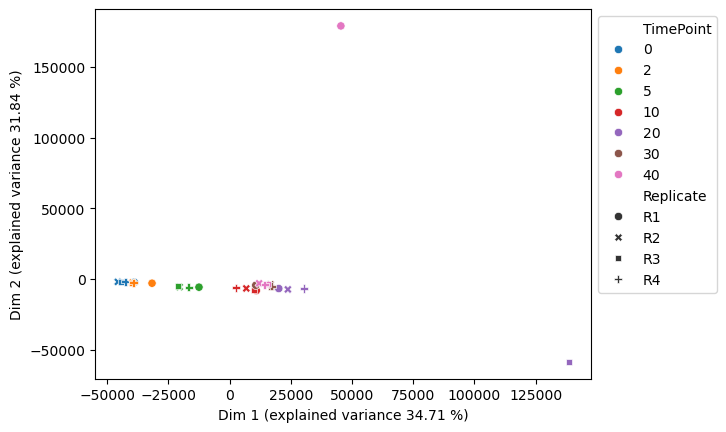

In [22]:
txPCA(tpms[columnOrder])

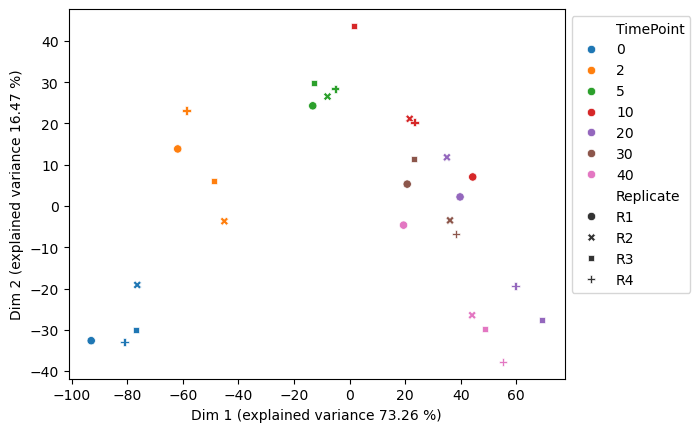

In [23]:
txPCA(logs[columnOrder])

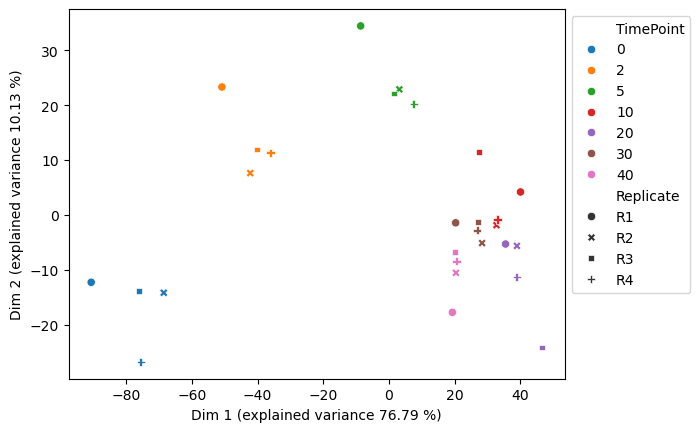

In [24]:
txPCA(logTPMs[columnOrder])

In [25]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

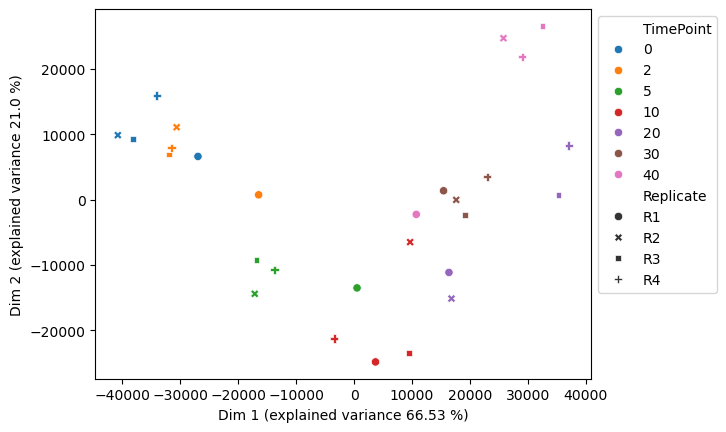

In [26]:
txPCA(tpmHost[columnOrder])

tpmPhage

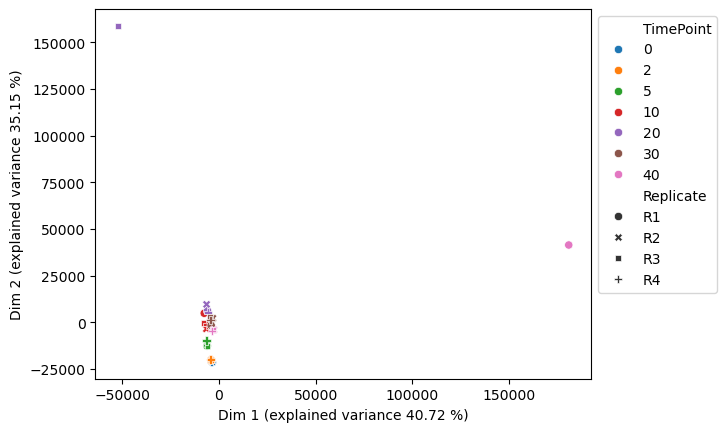

In [27]:
txPCA(tpmPhage[columnOrder])

logTPM Host

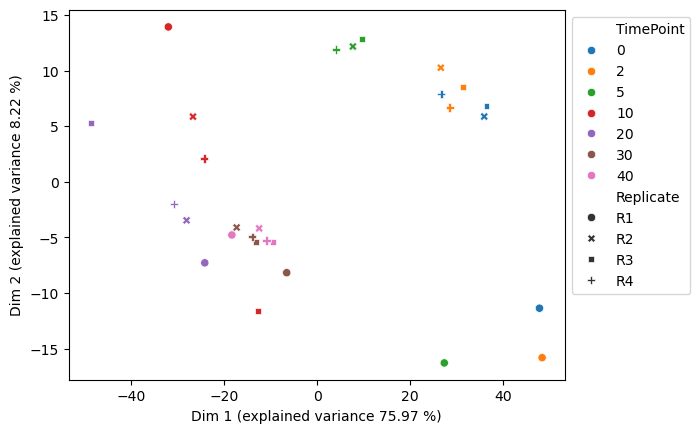

In [28]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

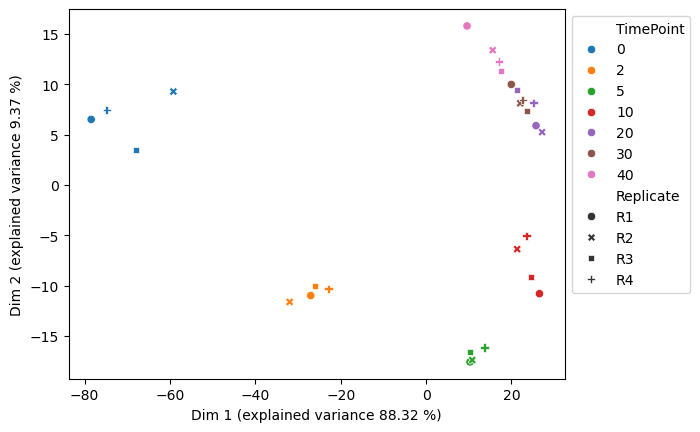

In [29]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Non logarithmized tpm phage values reveal clear outliers (20_R3, 40_R1), however log normalized values look good. Host logTPM look fine as well (R1 often a little off). Since authors did not remove any replicates in paper, we keep everything as well!

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [30]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '2', '5', '10', '20', '30', '40']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_858,267.239977,308.972149,244.558435,112.935071,83.732328,133.484602,102.989662,host,gene-NRS_858
gene-NRS_1657,161.123472,161.639223,106.195215,79.368829,68.725537,82.140891,82.966940,host,gene-NRS_1657
gene-NRS_2238,11316.209164,9951.127177,6068.089740,3823.652898,2805.547874,4013.544598,5520.568703,host,gene-NRS_2238
gene-NRS_968,148.737025,128.401305,99.967443,53.777742,42.085440,55.193291,56.330040,host,gene-NRS_968
gene-NRS_1015,235.616645,227.150000,160.148922,93.580087,71.079077,90.306249,74.755462,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,15.124962,14.092592,11.346761,7.889247,6.297871,9.588858,10.441671,host,gene-NRS_1750
gene-NRS_2148,187.214357,233.047216,135.778092,78.687925,67.678071,96.001010,93.048676,host,gene-NRS_2148
gene-NRS_1396,287.502222,276.673954,178.007497,102.256868,81.880216,133.105571,126.781455,host,gene-NRS_1396


In [31]:
TPMsds = TPMsds[['0', '2', '5', '10', '20', '30', '40']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_858,65.730018,55.017335,75.662281,34.293395,26.348561,7.743889,21.746669,host,gene-NRS_858
gene-NRS_1657,12.111007,11.407861,11.251729,15.870039,6.247372,2.947894,9.452753,host,gene-NRS_1657
gene-NRS_2238,1534.387738,1660.635345,1278.500370,996.051802,295.155899,297.850701,261.389419,host,gene-NRS_2238
gene-NRS_968,8.281074,6.065501,29.524989,9.714028,7.005296,3.782096,2.989134,host,gene-NRS_968
gene-NRS_1015,42.992018,63.747700,48.635776,17.437142,12.636454,2.774433,5.579444,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,1.319512,0.889044,1.027442,0.776585,1.070641,0.672383,0.551144,host,gene-NRS_1750
gene-NRS_2148,32.265414,44.011374,27.822717,8.932214,7.836019,16.482341,3.562196,host,gene-NRS_2148
gene-NRS_1396,49.451018,67.024744,57.419996,28.788039,35.410124,13.788062,18.114076,host,gene-NRS_1396


In [32]:
propExp = proportionalExp(TPMmeans[['0', '2', '5', '10', '20', '30', '40']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_858,0.864932,1.000000,0.791523,0.365519,0.271003,0.432028,0.333330,host,gene-NRS_858
gene-NRS_1657,0.996809,1.000000,0.656989,0.491025,0.425179,0.508174,0.513285,host,gene-NRS_1657
gene-NRS_2238,1.000000,0.879369,0.536230,0.337892,0.247923,0.354672,0.487846,host,gene-NRS_2238
gene-NRS_968,1.000000,0.863277,0.672109,0.361563,0.282952,0.371080,0.378722,host,gene-NRS_968
gene-NRS_1015,1.000000,0.964066,0.679701,0.397171,0.301673,0.383276,0.317276,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,1.000000,0.931744,0.750201,0.521604,0.416389,0.633976,0.690360,host,gene-NRS_1750
gene-NRS_2148,0.803332,1.000000,0.582621,0.337648,0.290405,0.411938,0.399270,host,gene-NRS_2148
gene-NRS_1396,1.000000,0.962337,0.619152,0.355673,0.284799,0.462972,0.440976,host,gene-NRS_1396


## 5. Phage gene classification

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [34]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [35]:
TPMmeans

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_858,267.239977,308.972149,244.558435,112.935071,83.732328,133.484602,102.989662,host,gene-NRS_858
gene-NRS_1657,161.123472,161.639223,106.195215,79.368829,68.725537,82.140891,82.966940,host,gene-NRS_1657
gene-NRS_2238,11316.209164,9951.127177,6068.089740,3823.652898,2805.547874,4013.544598,5520.568703,host,gene-NRS_2238
gene-NRS_968,148.737025,128.401305,99.967443,53.777742,42.085440,55.193291,56.330040,host,gene-NRS_968
gene-NRS_1015,235.616645,227.150000,160.148922,93.580087,71.079077,90.306249,74.755462,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,15.124962,14.092592,11.346761,7.889247,6.297871,9.588858,10.441671,host,gene-NRS_1750
gene-NRS_2148,187.214357,233.047216,135.778092,78.687925,67.678071,96.001010,93.048676,host,gene-NRS_2148
gene-NRS_1396,287.502222,276.673954,178.007497,102.256868,81.880216,133.105571,126.781455,host,gene-NRS_1396


In [36]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [37]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
middle    139
early      63
late       35
Name: count, dtype: int64

Add classes to other dfs.

In [39]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'CP027476.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_005880.2']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [40]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [41]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_858,378.024621,230.132380,251.818456,208.984450,389.465286,330.080791,254.896525,261.445993,375.252820,198.973686,209.694726,194.312506,146.460993,98.351330,143.389359,63.538602,111.647208,106.887059,49.321938,67.073107,141.554930,122.245287,130.410899,139.727294,94.866268,140.369984,88.813116,87.909279,host,gene-NRS_858,None,None,52.429397
gene-NRS_1657,163.159609,148.817052,152.504110,180.013117,181.246483,157.344453,153.518574,154.447381,122.120745,95.445677,111.475988,95.738449,56.428008,99.936661,75.296993,85.813652,65.956534,64.434112,65.006266,79.505238,86.892120,79.942718,79.433433,82.295295,72.402569,75.602047,88.004657,95.858486,host,gene-NRS_1657,None,None,13.642728
gene-NRS_2238,8680.684624,12513.132788,11990.895422,12080.123824,7079.415342,11010.173884,10956.587888,10758.331593,3920.134737,6620.666712,7282.063064,6449.494449,3096.095808,4101.565313,2771.601715,5325.348755,3015.307802,2723.432791,2361.213098,3122.237804,4444.858880,4125.664719,3807.389399,3676.265393,5220.953749,5938.728803,5432.623424,5489.968836,host,gene-NRS_2238,None,None,1624.345850
gene-NRS_968,162.550019,141.877861,142.782212,147.738009,138.801888,123.859237,124.698227,126.245867,150.549674,81.617710,89.857779,77.844610,37.452054,58.590151,62.811896,56.256869,50.639056,44.523479,31.261382,41.917845,60.798932,56.329323,52.765356,50.879552,51.540461,56.142482,58.383584,59.253634,host,gene-NRS_968,None,None,20.231226
gene-NRS_1015,307.094783,210.722698,229.344807,195.304292,337.519141,189.918717,193.129391,188.032750,244.251165,135.540156,132.975060,127.829307,79.852182,94.663743,121.658217,78.146207,85.709122,79.440091,52.857451,66.309646,94.160360,88.823165,91.457967,86.783503,68.129905,70.502735,81.492392,78.896818,host,gene-NRS_1015,None,None,41.409272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,13.324678,15.983158,16.723649,14.468363,12.648609,14.384223,15.073430,14.264107,9.987957,11.334512,12.879683,11.184894,6.894247,8.108718,7.544404,9.009618,7.589387,6.930886,4.759212,5.912000,10.349921,8.507604,9.682602,9.815305,10.091893,10.089123,11.393572,10.192095,host,gene-NRS_1750,None,None,0.884961
gene-NRS_2148,238.098974,175.071457,186.242862,149.444134,233.928294,161.043121,264.522383,272.695066,176.414537,114.113329,146.239297,106.345203,67.857839,72.923653,90.917901,83.052309,74.499595,72.020091,54.417950,69.774647,97.854271,121.653499,87.090775,77.405495,89.957855,89.302328,95.089718,97.844801,host,gene-NRS_2148,None,None,30.391268
gene-NRS_1396,371.696660,274.119348,253.922562,250.270319,392.638769,233.459649,242.252200,238.345198,277.372456,141.229616,148.063972,145.363943,76.896991,89.200659,151.159347,91.770476,128.696313,99.334083,34.681885,64.808584,156.743817,125.570964,122.293129,127.814374,123.508183,157.087189,116.261065,110.269382,host,gene-NRS_1396,None,None,45.242558


In [42]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [43]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_858,3969,2742,2644,2653,3839,3262,2677,3718,3018,2106,2354,2156,1327,1227,2148,749,963,1111,353,427,1214,946,1236,972,942,780,428,378,host,gene-NRS_858
gene-NRS_1657,10533,10903,9846,14052,10985,9561,9914,13505,6039,6212,7695,6532,3144,7668,6936,6223,3499,4119,2864,3115,4583,3805,4630,3521,4422,2584,2610,2537,host,gene-NRS_1657
gene-NRS_2238,103531,169370,143024,174212,79269,123602,130720,173793,35815,79610,92868,81297,31873,58142,47168,71348,29555,32166,19221,22602,43314,36281,41002,29061,58914,37505,29770,26847,host,gene-NRS_2238
gene-NRS_968,11758,11647,10329,12922,9426,8433,9023,12369,8342,5952,6950,5951,2338,5037,6483,4571,3010,3189,1543,1840,3593,3004,3446,2439,3527,2150,1940,1757,host,gene-NRS_968
gene-NRS_1015,8320,6479,6214,6398,8585,4843,5234,6900,5069,3702,3852,3660,1867,3048,4703,2378,1908,2131,977,1090,2084,1774,2237,1558,1746,1011,1014,876,host,gene-NRS_1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_1750,744,1013,934,977,663,756,842,1079,427,638,769,660,332,538,601,565,348,383,181,200,472,350,488,363,533,298,292,233,host,gene-NRS_1750
gene-NRS_2148,9599,8010,7509,7285,8854,6111,10668,14891,5448,4638,6304,4531,2361,3494,5230,3761,2468,2875,1497,1707,3223,3616,3170,2068,3431,1906,1761,1617,host,gene-NRS_2148
gene-NRS_1396,23466,19640,16032,19105,23272,13873,15299,20381,13414,8989,9995,9699,4190,6693,13617,6508,6677,6210,1494,2483,8085,5845,6971,5348,7377,5251,3372,2854,host,gene-NRS_1396


In [44]:
# Full TPM table
tpms.to_csv('Kongari_rpoC_G17D_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Kongari_rpoC_G17D_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Kongari_rpoC_G17D_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Kongari_rpoC_G17D_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Kongari_rpoC_G17D_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Kongari_rpoC_G17D_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Kongari_rpoC_G17D_phage_gff3.tsv', sep='\t')